# Sleep Efficiency — ML Final Project (Single Notebook)

### Imports e paths:

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier


from sklearn.model_selection import GroupShuffleSplit
from sklearn.dummy import DummyClassifier


import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

DATA_PATH = Path('./data/sleep.csv')
REPORTS_DIR = Path('reports')
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print('Usando DATA_PATH =', DATA_PATH.resolve())

Usando DATA_PATH = /home/vini/dev/machine-learning-final-project/src/data/sleep.csv


## Análise de DataFrame:

In [2]:
def load_data(path: Path) -> pd.DataFrame:
    return pd.read_csv(path)
df = load_data(DATA_PATH)
df.head()

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


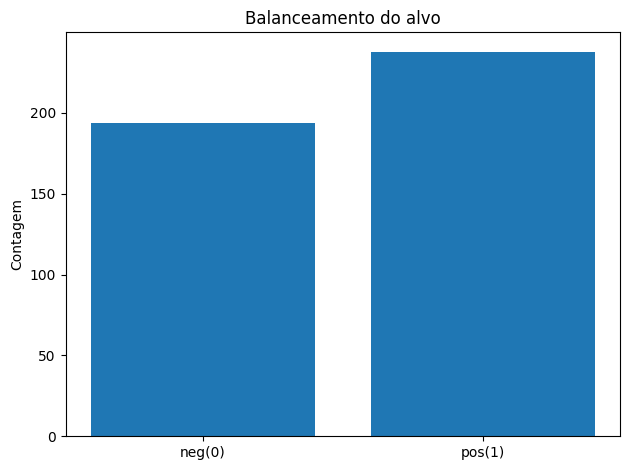

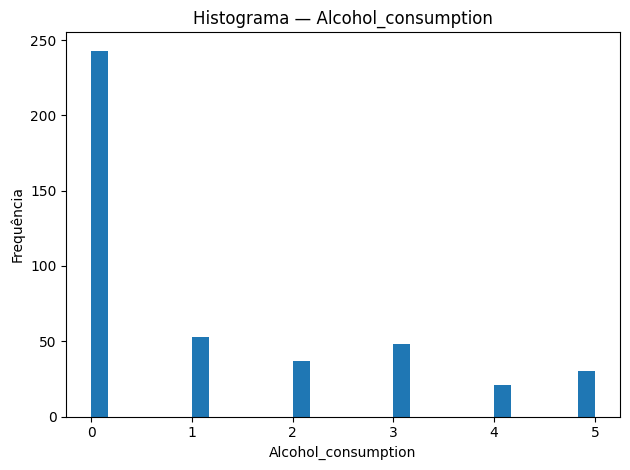

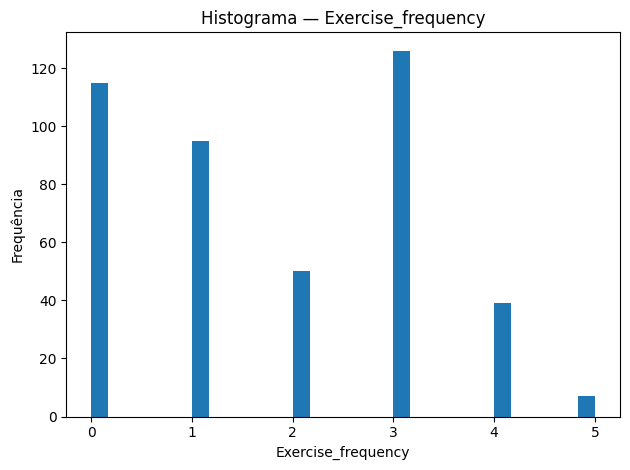

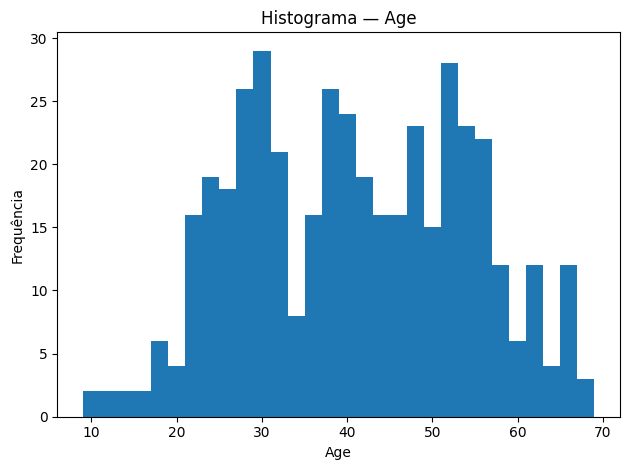

/tmp/ipykernel_8427/1050279308.py:161: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([vals0, vals1], labels=['y=0','y=1'])


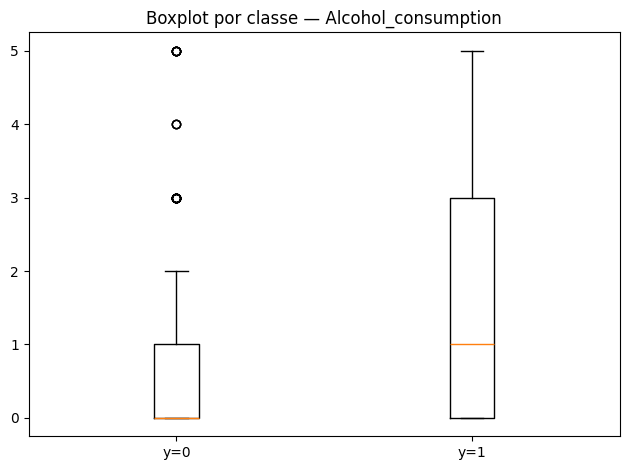

/tmp/ipykernel_8427/1050279308.py:161: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([vals0, vals1], labels=['y=0','y=1'])


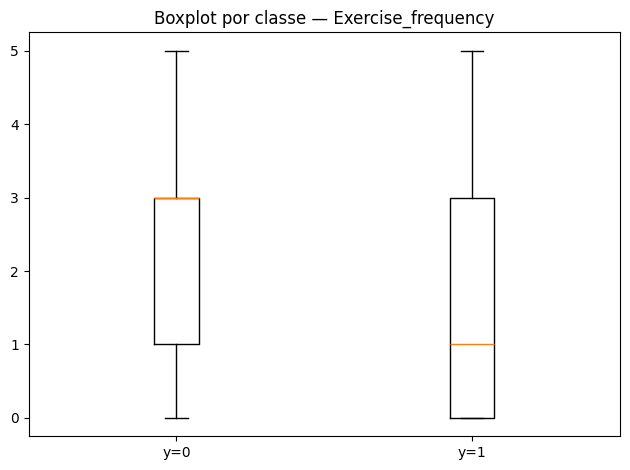

/tmp/ipykernel_8427/1050279308.py:161: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([vals0, vals1], labels=['y=0','y=1'])


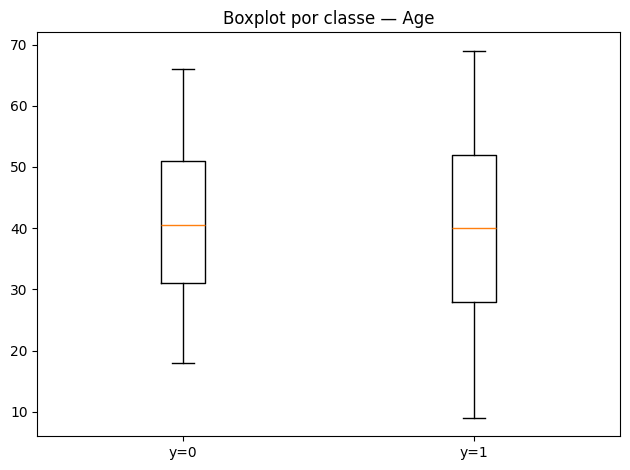

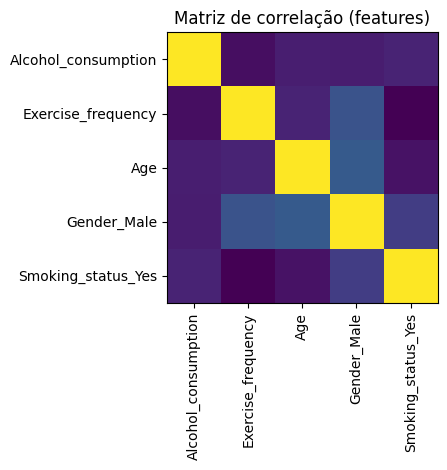

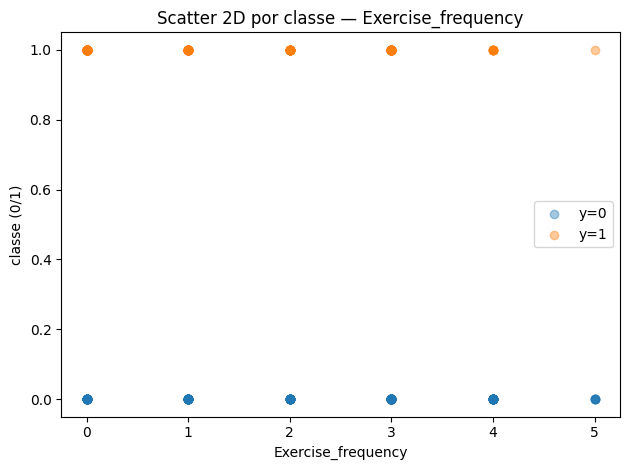

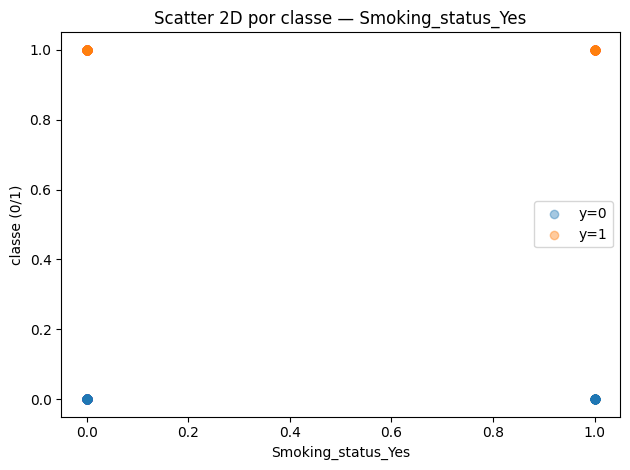

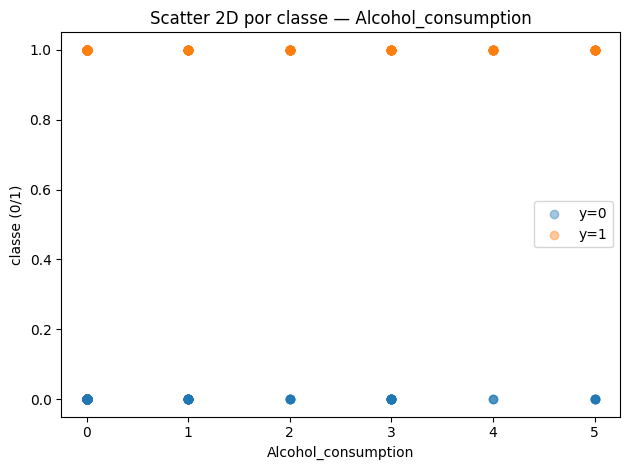

/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


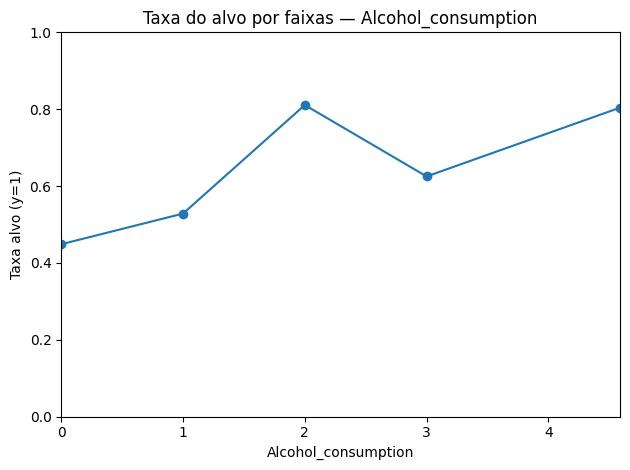

/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


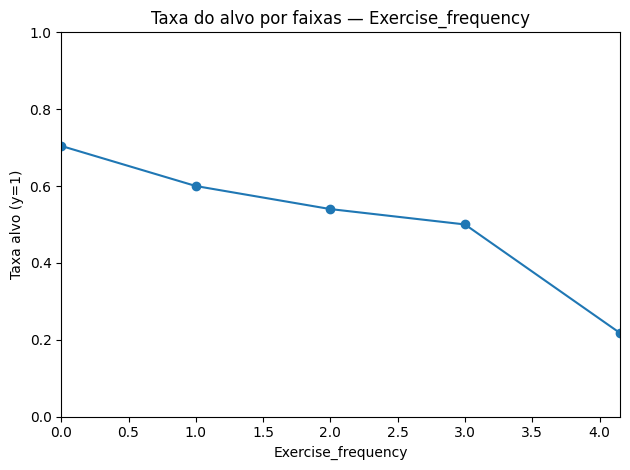

/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


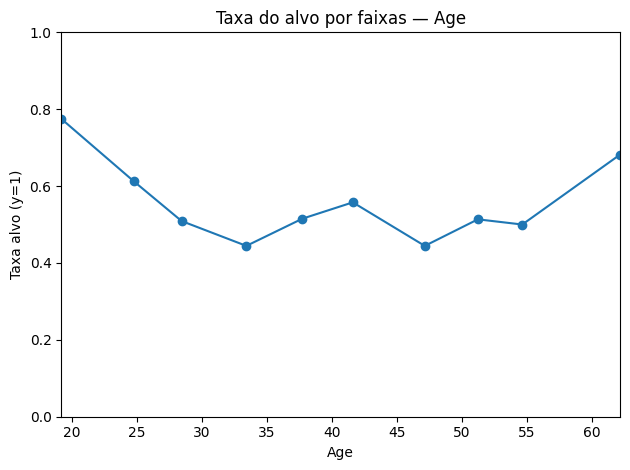

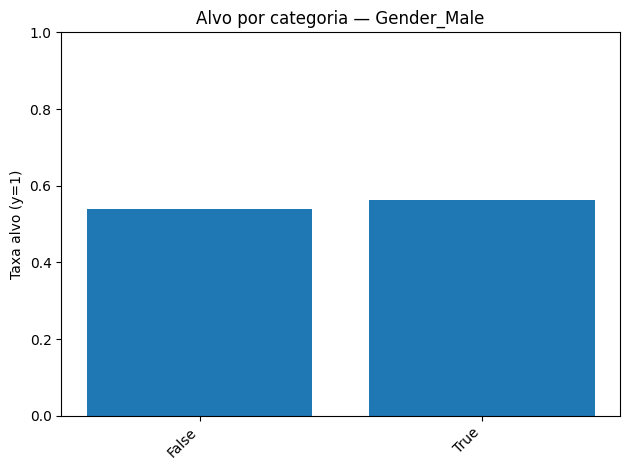

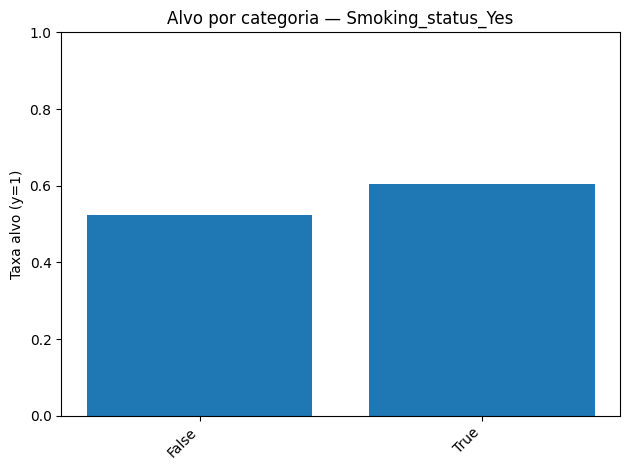

Arquivos gerados em: /home/vini/dev/machine-learning-final-project/src/reports
- Balanceamento: reports/eda_target_balance.png
- Hist: 3 arquivos
- Boxplots: 3 arquivos
- Heatmap de correlação: reports/eda_corr_heatmap.png
- MI CSV: /home/vini/dev/machine-learning-final-project/src/reports/eda_mutual_info.csv
- Corr(y) CSV: /home/vini/dev/machine-learning-final-project/src/reports/eda_corr_with_y.csv


In [3]:
from sklearn.feature_selection import mutual_info_classif


def make_target(df: pd.DataFrame) -> pd.Series:
    return (df["Sleep efficiency"] < 0.85).astype(int)


def _ensure_numpy(x):
    return np.asarray(x, dtype=float)

def _circ(ts):
    if pd.isna(ts): return np.nan, np.nan
    rad = (ts.hour + ts.minute/60.0)/24.0 * 2*np.pi
    return np.cos(rad), np.sin(rad)

def engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    bt = pd.to_datetime(df.get("Bedtime"), errors="coerce")
    wu = pd.to_datetime(df.get("Wakeup time"), errors="coerce")

    bt_cs = bt.apply(_circ).apply(pd.Series)
    wu_cs = wu.apply(_circ).apply(pd.Series)
    df["bt_cos"], df["bt_sin"] = bt_cs[0], bt_cs[1]
    df["wu_cos"], df["wu_sin"] = wu_cs[0], wu_cs[1]

    for col in ["Gender", "Smoking status"]:
        if col in df.columns:
            df[col] = df[col].astype("category")

    df = pd.get_dummies(
        df,
        columns=[c for c in ["Gender", "Smoking status"] if c in df.columns],
        drop_first=True,
    )

    keep = [
        "Caffeine intake", "Alcohol consumption", "Exercise frequency",
        "Age",
    ] + [c for c in df.columns if c.startswith("Gender_") or c.startswith("Smoking status_")]

    df = df.reindex(columns=keep)

    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)
    df = df.loc[:, df.notna().any(axis=0)]  
    const = df.nunique(dropna=False) <= 1   
    df = df.loc[:, ~const]

    return df

def sanitize_features_targets(Xf: pd.DataFrame, y: pd.Series):
    Xf = Xf.copy()

    Xf.columns = Xf.columns.map(lambda c: str(c).strip().replace(" ", "_"))

    for col in Xf.columns:
        if not np.issubdtype(Xf[col].dtype, np.number):
            Xf[col] = pd.to_numeric(Xf[col], errors="coerce")

    Xf = Xf.loc[:, Xf.notna().any(axis=0)]
    const_mask = Xf.nunique(dropna=False) <= 1
    if const_mask.any():
        Xf = Xf.loc[:, ~const_mask]

    arr = Xf.to_numpy(dtype=float, copy=False)
    finite_mask = np.isfinite(arr).all(axis=1)
    Xf = Xf.loc[finite_mask]
    y = y.loc[Xf.index]

    Xf = Xf.dropna(axis=0)
    y = y.loc[Xf.index].astype(int)
    y.index = Xf.index

    return Xf, y

def _bin_rate_plot(ax, x, y, n_bins=10, strategy="quantile"):
    """
    Plota taxa do alvo por bin de x.
    """
    x = _ensure_numpy(x)
    y = _ensure_numpy(y)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]


    kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    x_b = kbd.fit_transform(x.reshape(-1,1)).ravel()

    means = []
    centers = []
    for b in range(n_bins):
        m = (x_b == b)
        if m.sum() == 0:
            means.append(np.nan)
            centers.append(np.nan)
            continue
        means.append(float(y[m].mean()))
        centers.append(float(x[m].mean()))
    ax.plot(centers, means, marker='o')
    ax.set_xlim(np.nanmin(centers), np.nanmax(centers))
    ax.set_ylim(0, 1)
    ax.set_ylabel('Taxa alvo (y=1)')

def _bar_rate(ax, s, y, title=None):
    """
    Para variáveis categóricas (dummies ou discretas): média do alvo por categoria.
    """
    df_tmp = pd.DataFrame({'cat': s, 'y': y})
    df_tmp = df_tmp[np.isfinite(df_tmp['y'])]
    grp = df_tmp.groupby('cat', dropna=True)['y'].mean().sort_values()
    ax.bar(range(len(grp)), grp.values)
    ax.set_xticks(range(len(grp)))
    ax.set_xticklabels([str(k) for k in grp.index], rotation=45, ha='right')
    ax.set_ylim(0, 1)
    if title:
        ax.set_title(title)
    ax.set_ylabel('Taxa alvo (y=1)')

def run_eda_plots():
    raw = load_data(DATA_PATH)
    y = make_target(raw)
    X_eng = engineer(raw)
    X_eng, y_aligned = sanitize_features_targets(X_eng, y)

    cols = list(X_eng.columns)
    cat_cols = [c for c in cols if c.startswith('Gender_') or c.startswith('Smoking_status_')]
    num_cols = [c for c in cols if c not in cat_cols]

    plt.figure()
    counts = y_aligned.value_counts().sort_index()
    plt.bar(['neg(0)', 'pos(1)'], [int(counts.get(0,0)), int(counts.get(1,0))])
    plt.title('Balanceamento do alvo')
    plt.ylabel('Contagem')
    p_bal = REPORTS_DIR / 'eda_target_balance.png'
    plt.tight_layout(); plt.savefig(p_bal); plt.show()
    

    hist_paths = []
    for c in num_cols:
        data = X_eng[c].to_numpy(dtype=float)
        data = data[np.isfinite(data)]
        if data.size == 0:
            continue
        plt.figure()
        plt.hist(data, bins=30)
        plt.title(f'Histograma — {c}')
        plt.xlabel(c)
        plt.ylabel('Frequência')
        p = REPORTS_DIR / f'eda_hist_{c}.png'
        plt.tight_layout(); plt.savefig(p); plt.show()
        hist_paths.append(str(p))

    box_paths = []
    for c in num_cols:
        dfb = pd.DataFrame({c: X_eng[c], 'y': y_aligned})
        dfb = dfb[np.isfinite(dfb[c])]
        plt.figure()
        
        vals0 = dfb.loc[dfb['y']==0, c].to_numpy()
        vals1 = dfb.loc[dfb['y']==1, c].to_numpy()
        plt.boxplot([vals0, vals1], labels=['y=0','y=1'])
        plt.title(f'Boxplot por classe — {c}')
        p = REPORTS_DIR / f'eda_box_{c}.png'
        plt.tight_layout(); plt.savefig(p); plt.show()
        box_paths.append(str(p))

    corr = X_eng.corr(numeric_only=True)
    plt.figure()
    plt.imshow(corr, interpolation='nearest')
    plt.title('Matriz de correlação (features)')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    p_corr = REPORTS_DIR / 'eda_corr_heatmap.png'
    plt.tight_layout(); plt.savefig(p_corr); plt.show()

    y_num = y_aligned.to_numpy(dtype=float)
    corr_y = []
    for c in num_cols + cat_cols:
        x = X_eng[c].to_numpy(dtype=float)
        m = np.isfinite(x) & np.isfinite(y_num)
        if m.sum() < 3:
            r = np.nan
        else:
            r = np.corrcoef(x[m], y_num[m])[0,1]
        corr_y.append((c, float(r)))
    corr_y_sorted = sorted(corr_y, key=lambda t: (np.nan if np.isnan(t[1]) else abs(t[1])), reverse=True)
    pd.DataFrame(corr_y_sorted, columns=['feature','corr_with_y']).to_csv(REPORTS_DIR/'eda_corr_with_y.csv', index=False)

    X_mi = X_eng.copy()
    for c in X_mi.columns:
        if not np.issubdtype(X_mi[c].dtype, np.number):
            X_mi[c] = pd.to_numeric(X_mi[c], errors='coerce')
        med = X_mi[c].median()
        X_mi[c] = X_mi[c].fillna(med)
    mi = mutual_info_classif(X_mi.values, y_aligned.values, random_state=0)
    mi_table = pd.DataFrame({'feature': X_mi.columns, 'mutual_info': mi}).sort_values('mutual_info', ascending=False)
    mi_table.to_csv(REPORTS_DIR/'eda_mutual_info.csv', index=False)

    top_feats = mi_table['feature'].tolist()[:3]
    scatter_paths = []
    for c in top_feats:
        plt.figure()
        x = X_eng[c].to_numpy(dtype=float)
        m = np.isfinite(x) & np.isfinite(y_num)
        plt.scatter(x[m][y_num[m]==0], np.zeros((y_num[m]==0).sum()), alpha=0.4, label='y=0')
        plt.scatter(x[m][y_num[m]==1], np.ones((y_num[m]==1).sum()), alpha=0.4, label='y=1')
        plt.xlabel(c); plt.ylabel('classe (0/1)')
        plt.title(f'Scatter 2D por classe — {c}')
        plt.legend()
        p = REPORTS_DIR / f'eda_scatter_{c}.png'
        plt.tight_layout(); plt.savefig(p); plt.show()
        scatter_paths.append(str(p))
        
    rate_paths = []
    for c in num_cols[:6]:
        plt.figure()
        ax = plt.gca()
        _bin_rate_plot(ax, X_eng[c], y_aligned, n_bins=10, strategy='quantile')
        plt.xlabel(c)
        plt.title(f'Taxa do alvo por faixas — {c}')
        p = REPORTS_DIR / f'eda_rate_bins_{c}.png'
        plt.tight_layout(); plt.savefig(p); plt.show()
        rate_paths.append(str(p))

    cat_paths = []
    for c in cat_cols:
        plt.figure()
        ax = plt.gca()
        _bar_rate(ax, X_eng[c], y_aligned, title=f'Alvo por categoria — {c}')
        p = REPORTS_DIR / f'eda_bar_{c}.png'
        plt.tight_layout(); plt.savefig(p); plt.show()
        cat_paths.append(str(p))

    if 'bt_cos' in X_eng.columns and 'bt_sin' in X_eng.columns:
        bt_ang = np.arctan2(X_eng['bt_sin'], X_eng['bt_cos'])
        plt.figure()
        ax = plt.subplot(111, projection='polar')
        ax.scatter(bt_ang[y_aligned==0], np.ones((y_aligned==0).sum()), alpha=0.5, label='y=0 (bedtime)')
        ax.scatter(bt_ang[y_aligned==1], np.ones((y_aligned==1).sum())*1.1, alpha=0.5, label='y=1 (bedtime)')
        ax.set_title('Distribuição polar — Bedtime')
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
        p = REPORTS_DIR / 'eda_polar_bedtime.png'
        plt.tight_layout(); plt.savefig(p); plt.show()

    if 'wu_cos' in X_eng.columns and 'wu_sin' in X_eng.columns:
        wu_ang = np.arctan2(X_eng['wu_sin'], X_eng['wu_cos'])
        plt.figure()
        ax = plt.subplot(111, projection='polar')
        ax.scatter(wu_ang[y_aligned==0], np.ones((y_aligned==0).sum()), alpha=0.5, label='y=0 (wakeup)')
        ax.scatter(wu_ang[y_aligned==1], np.ones((y_aligned==1).sum())*1.1, alpha=0.5, label='y=1 (wakeup)')
        ax.set_title('Distribuição polar — Wakeup time')
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
        p = REPORTS_DIR / 'eda_polar_wakeup.png'
        plt.tight_layout(); plt.savefig(p); plt.show()

    print("Arquivos gerados em:", REPORTS_DIR.resolve())
    print("- Balanceamento:", str(p_bal))
    print("- Hist:", len(hist_paths), "arquivos")
    print("- Boxplots:", len(box_paths), "arquivos")
    print("- Heatmap de correlação:", str(p_corr))
    print("- MI CSV:", str((REPORTS_DIR/'eda_mutual_info.csv').resolve()))
    print("- Corr(y) CSV:", str((REPORTS_DIR/'eda_corr_with_y.csv').resolve()))

run_eda_plots()

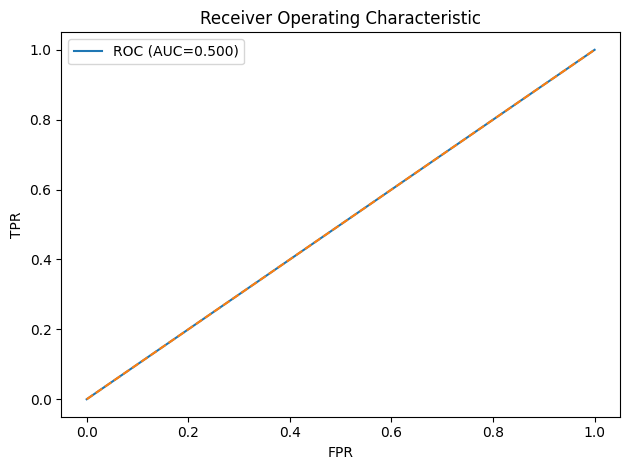

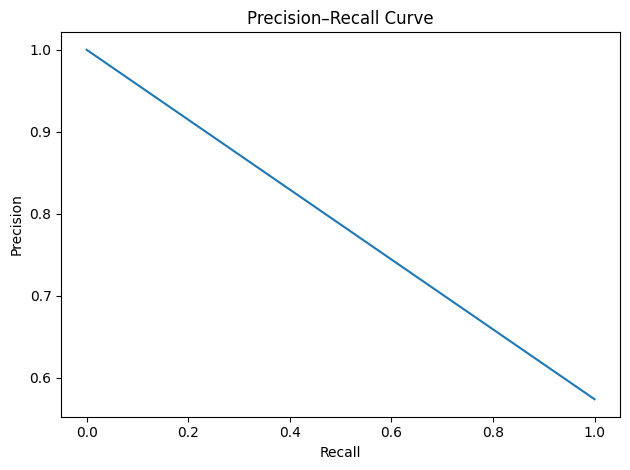

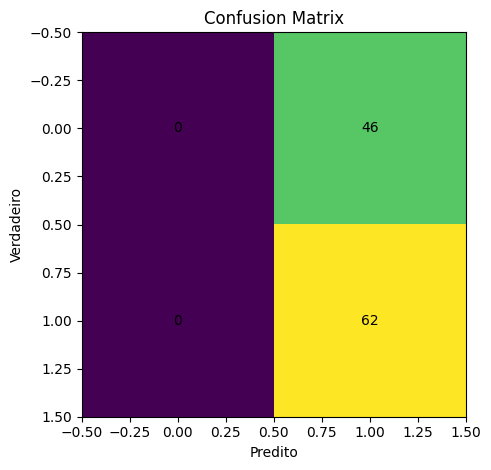

/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

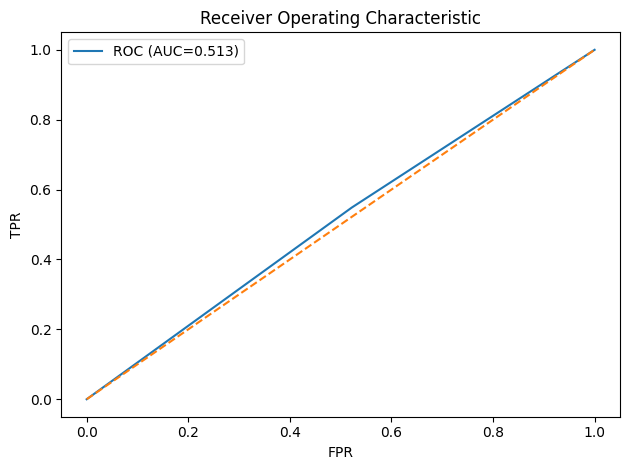

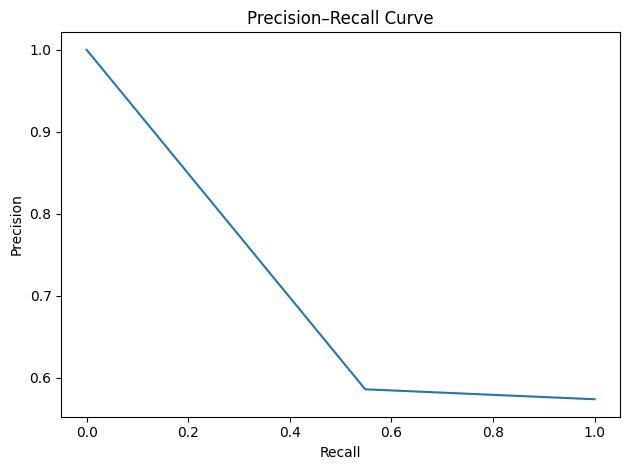

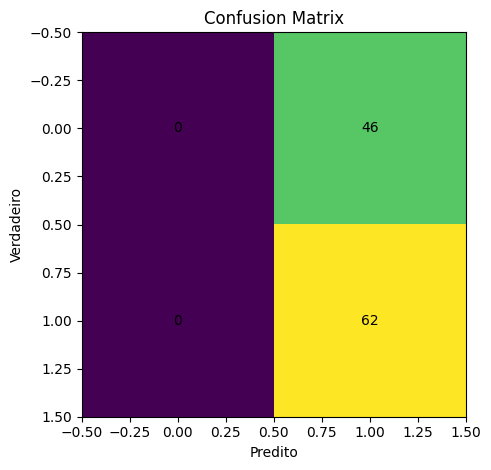

{
  "n_samples_total": 432,
  "n_features": 9,
  "n_groups": 432,
  "class_balance": {
    "pos": 238,
    "neg": 194
  },
  "dummy_reports": {
    "dummy_most_frequent": {
      "strategy": "most_frequent",
      "test_size": 108,
      "train_size": 324,
      "auc_test": 0.5,
      "precision_pos": 0.5740740740740741,
      "recall_pos": 1.0,
      "f1_pos": 0.7294117647058823,
      "threshold": 1.0,
      "plots": {
        "roc": "reports/dummy_most_frequent_test_roc.png",
        "pr": "reports/dummy_most_frequent_test_pr.png",
        "cm": "reports/dummy_most_frequent_test_cm.png"
      }
    },
    "dummy_stratified": {
      "strategy": "stratified",
      "test_size": 108,
      "train_size": 324,
      "auc_test": 0.5133239831697054,
      "precision_pos": 0.5740740740740741,
      "recall_pos": 1.0,
      "f1_pos": 0.7294117647058823,
      "threshold": 0.0,
      "plots": {
        "roc": "reports/dummy_stratified_test_roc.png",
        "pr": "reports/dummy_stratified_te

/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

In [4]:

def engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    bt = pd.to_datetime(df.get("Bedtime"), errors="coerce")
    wu = pd.to_datetime(df.get("Wakeup time"), errors="coerce")
    df["bt_cos"], df["bt_sin"] = zip(*bt.apply(_circ))
    df["wu_cos"], df["wu_sin"] = zip(*wu.apply(_circ))

    base_cols = [
        "Caffeine intake","Alcohol consumption","Exercise frequency","Age"
    ]
    df = pd.get_dummies(
        df,
        columns=[c for c in ["Gender","Smoking status"] if c in df.columns],
        drop_first=True
    )
    keep = [
        "bt_cos","bt_sin","wu_cos","wu_sin",
        *base_cols,
        *[c for c in df.columns if c.startswith("Gender_") or c.startswith("Smoking status_")]
    ]
    df = df.reindex(columns=keep)
    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)

    df = df.loc[:, df.notna().any()]
    const_mask = df.nunique(dropna=False) <= 1
    df = df.loc[:, ~const_mask]
    return df

def sanitize_features_targets(Xf: pd.DataFrame, y: pd.Series):
    Xf = Xf.copy()
    Xf.columns = Xf.columns.map(lambda c: str(c).strip().replace(" ", "_"))
    for col in Xf.columns:
        if not np.issubdtype(Xf[col].dtype, np.number):
            Xf[col] = pd.to_numeric(Xf[col], errors="coerce")
    Xf = Xf.loc[:, Xf.notna().any(axis=0)]
    const_mask = Xf.nunique(dropna=False) <= 1
    if const_mask.any():
        Xf = Xf.loc[:, ~const_mask]
    arr = Xf.to_numpy(dtype=float, copy=False)
    finite_mask = np.isfinite(arr).all(axis=1)
    Xf = Xf.loc[finite_mask]
    y = y.loc[Xf.index]
    Xf = Xf.dropna(axis=0)
    y = y.loc[Xf.index]
    return Xf, y

def plot_and_save_curves(y_true, prob, thr, prefix: str):
    fpr, tpr, _ = roc_curve(y_true, prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_true, prob):.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.tight_layout()
    p1 = REPORTS_DIR/f"{prefix}_roc.png"
    plt.savefig(p1)
    plt.show()

    pr, re, _ = precision_recall_curve(y_true, prob)
    plt.figure()
    plt.plot(re, pr)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curve')
    plt.tight_layout()
    p2 = REPORTS_DIR/f"{prefix}_pr.png"
    plt.savefig(p2)
    plt.show()

    y_pred = (prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.tight_layout()
    p3 = REPORTS_DIR/f"{prefix}_cm.png"
    plt.savefig(p3)
    plt.show()
    return str(p1), str(p2), str(p3)

def dummy_pipeline(strategy="most_frequent", random_state=42):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf",     DummyClassifier(strategy=strategy, random_state=random_state))
    ])


df = load_data(DATA_PATH)
y_full = make_target(df)
Xf_full = engineer(df)
Xf_full, y_full = sanitize_features_targets(Xf_full, y_full)

groups_all = df.get("Subject ID", pd.Series(np.arange(len(df), dtype=int), index=df.index))
groups_all = pd.Series(groups_all).loc[Xf_full.index]

gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=123)
train_idx, test_idx = next(gss.split(Xf_full, y_full, groups=groups_all))
X_tr, X_te = Xf_full.iloc[train_idx], Xf_full.iloc[test_idx]
y_tr, y_te = y_full.iloc[train_idx], y_full.iloc[test_idx]

reports = {}

for name, strat in [("dummy_most_frequent","most_frequent"),
                    ("dummy_stratified","stratified")]:
    pipe = dummy_pipeline(strategy=strat, random_state=123)
    pipe.fit(X_tr, y_tr)
    prob_te = pipe.predict_proba(X_te)[:,1]

    prec, rec, thr = precision_recall_curve(y_te, prob_te)
    f1s = 2*(prec*rec)/(prec+rec+1e-12)
    best_idx = int(np.nanargmax(f1s))
    best_thr = 0.5 if best_idx==len(thr) else float(thr[best_idx])

    p_roc, p_pr, p_cm = plot_and_save_curves(y_te, prob_te, best_thr, prefix=f"{name}_test")

    y_pred = (prob_te >= best_thr).astype(int)
    rep = classification_report(y_te, y_pred, output_dict=True)

    reports[name] = {
        "strategy": strat,
        "test_size": int(X_te.shape[0]),
        "train_size": int(X_tr.shape[0]),
        "auc_test": float(roc_auc_score(y_te, prob_te)),
        "precision_pos": float(rep["1"]["precision"]),
        "recall_pos": float(rep["1"]["recall"]),
        "f1_pos": float(rep["1"]["f1-score"]),
        "threshold": best_thr,
        "plots": {"roc": p_roc, "pr": p_pr, "cm": p_cm}
    }

print(json.dumps({
    "n_samples_total": int(len(y_full)),
    "n_features": int(Xf_full.shape[1]),
    "n_groups": int(pd.Series(groups_all).nunique()),
    "class_balance": {
        "pos": int(y_full.sum()),
        "neg": int((1 - y_full).sum())
    },
    "dummy_reports": reports
}, indent=2))


In [5]:
def engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    bt = pd.to_datetime(df.get("Bedtime"), errors="coerce")
    wu = pd.to_datetime(df.get("Wakeup time"), errors="coerce")

    bt_cs = bt.apply(_circ).apply(pd.Series)
    wu_cs = wu.apply(_circ).apply(pd.Series)
    df["bt_cos"], df["bt_sin"] = bt_cs[0], bt_cs[1]
    df["wu_cos"], df["wu_sin"] = wu_cs[0], wu_cs[1]

    for col in ["Gender", "Smoking status"]:
        if col in df.columns:
            df[col] = df[col].astype("category")

    df = pd.get_dummies(
        df,
        columns=[c for c in ["Gender", "Smoking status"] if c in df.columns],
        drop_first=True,
    )

    keep = [
        "Caffeine intake", "Alcohol consumption", "Exercise frequency",
        "Age",
    ] + [c for c in df.columns if c.startswith("Gender_") or c.startswith("Smoking status_")]

    df = df.reindex(columns=keep)

    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)
    df = df.loc[:, df.notna().any(axis=0)]  
    const = df.nunique(dropna=False) <= 1   
    df = df.loc[:, ~const]

    return df

def sanitize_features_targets(Xf: pd.DataFrame, y: pd.Series):
    Xf = Xf.copy()

    Xf.columns = Xf.columns.map(lambda c: str(c).strip().replace(" ", "_"))

    for col in Xf.columns:
        if not np.issubdtype(Xf[col].dtype, np.number):
            Xf[col] = pd.to_numeric(Xf[col], errors="coerce")

    Xf = Xf.loc[:, Xf.notna().any(axis=0)]
    const_mask = Xf.nunique(dropna=False) <= 1
    if const_mask.any():
        Xf = Xf.loc[:, ~const_mask]

    arr = Xf.to_numpy(dtype=float, copy=False)
    finite_mask = np.isfinite(arr).all(axis=1)
    Xf = Xf.loc[finite_mask]
    y = y.loc[Xf.index]

    Xf = Xf.dropna(axis=0)
    y = y.loc[Xf.index].astype(int)
    y.index = Xf.index

    return Xf, y


In [6]:
def logistic_pipe():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))
    ])

def gbm_pipe():
    clf = LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        num_leaves=31,
        min_child_samples=10,
        n_jobs=1,
        random_state=42,
    )
    return CalibratedClassifierCV(clf, method="sigmoid", cv=3, n_jobs=1)

def metrics(y_true, prob, thr=0.5):
    y_pred = (prob >= thr).astype(int)
    return {
        "auc": roc_auc_score(y_true, prob),
        "f1": f1_score(y_true, y_pred)
    }


In [7]:
Xf = engineer(df)
y = make_target(df)
Xf, y = sanitize_features_targets(Xf, y)

groups = df.get("ID", pd.Series(np.arange(len(df), dtype=int), index=df.index))
groups = pd.Series(groups).loc[Xf.index]

gkf = GroupKFold(n_splits=max(2, min(5, int(pd.Series(groups).nunique()))))
candidates = [("log_reg", logistic_pipe), ("gbm", gbm_pipe)]

results = []
best_name, best_auc = None, -np.inf
best_builder = None
for name, builder in candidates:
    fold_scores = []
    for trn_idx, val_idx in gkf.split(Xf, y, groups):
        model = builder()
        X_tr, y_tr = Xf.iloc[trn_idx], y.iloc[trn_idx]
        X_va, y_va = Xf.iloc[val_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        prob = model.predict_proba(X_va)[:, 1]
        fold_scores.append(metrics(y_va, prob))
    results.append((name, fold_scores))
    auc_mean = float(np.mean([s["auc"] for s in fold_scores]))
    if auc_mean > best_auc:
        best_auc = auc_mean
        best_name = name
        best_builder = builder

rng = np.random.default_rng(123)
y_shuf = pd.Series(rng.permutation(y.values), index=y.index)
results_shuf = []
for name, builder in candidates:
    fold_scores = []
    for trn_idx, val_idx in gkf.split(Xf, y_shuf, groups):
        model = builder()
        X_tr, y_tr = Xf.iloc[trn_idx], y_shuf.iloc[trn_idx]
        X_va, y_va = Xf.iloc[val_idx], y_shuf.iloc[val_idx]
        model.fit(X_tr, y_tr)
        prob = model.predict_proba(X_va)[:, 1]
        fold_scores.append(metrics(y_va, prob))
    results_shuf.append((name, fold_scores))

summary = {
    "best_model": best_name,
    "best_auc_cv": best_auc,
    "cv_details": results,
    "cv_details_shuffled_y": results_shuf,
    "n_rows_train": int(Xf.shape[0]),
    "n_cols_train": int(Xf.shape[1]),
    "n_groups": int(pd.Series(groups).nunique()),
}
print(json.dumps(summary, indent=2))

with open(REPORTS_DIR/"train_debug.json", "w") as f:
    json.dump(summary, f, indent=2)

[LightGBM] [Info] Number of positive: 125, number of negative: 105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 230, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543478 -> initscore=0.174353
[LightGBM] [Info] Start training from score 0.174353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Number of positive: 159, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552083 -> initscore=0.209092
[LightGBM] [Info] Start training from score 0.209092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

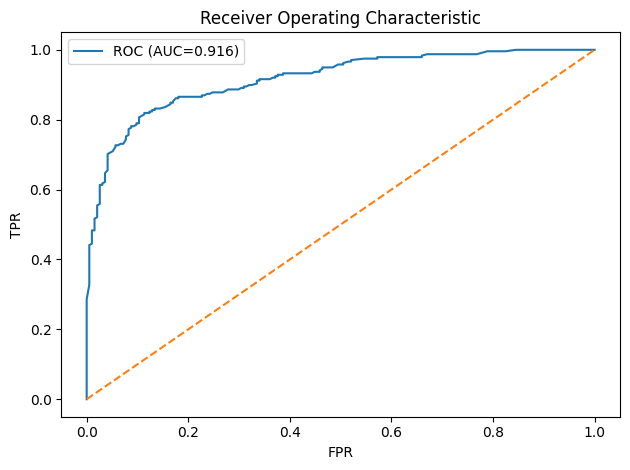

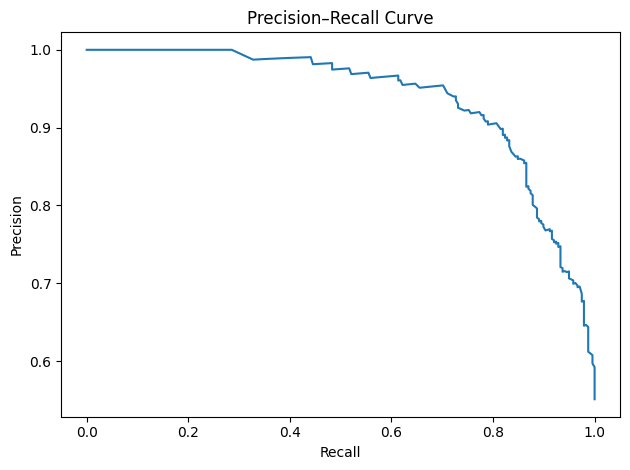

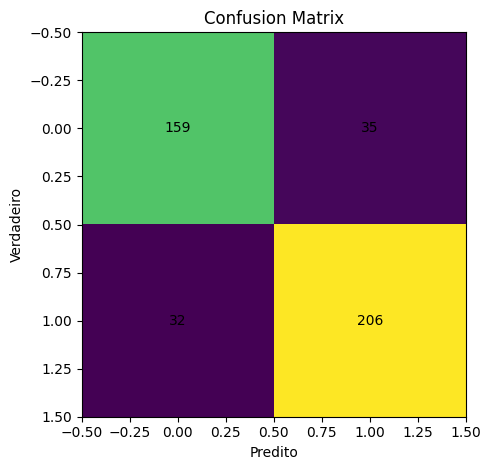

{
  "threshold": 0.5048434390478295,
  "auc": 0.916312916919345,
  "precision": 0.8547717842323651,
  "recall": 0.865546218487395,
  "f1": 0.860125260960334,
  "support_pos": 238,
  "n_samples": 432,
  "plots": {
    "roc": "reports/holdin_roc.png",
    "pr": "reports/holdin_pr.png",
    "cm": "reports/holdin_cm.png"
  }
}


In [8]:
assert best_builder is not None
final_model = best_builder()
final_model.fit(Xf, y)

prob_all = final_model.predict_proba(Xf)[:,1]

prec, rec, thr = precision_recall_curve(y, prob_all)
f1s = 2*(prec*rec)/(prec+rec + 1e-12)
best_idx = int(np.nanargmax(f1s))
best_thr = 0.5 if best_idx == len(thr) else float(thr[best_idx])
print('Limiar escolhido (F1-max):', best_thr)

def plot_and_save_curves(y_true, prob, thr, prefix: str):
    fpr, tpr, _ = roc_curve(y_true, prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_true, prob):.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.tight_layout()
    p1 = REPORTS_DIR/f"{prefix}_roc.png"
    plt.savefig(p1)
    plt.show()

    prc, rec_, _ = precision_recall_curve(y_true, prob)
    plt.figure()
    plt.plot(rec_, prc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curve')
    plt.tight_layout()
    p2 = REPORTS_DIR/f"{prefix}_pr.png"
    plt.savefig(p2)
    plt.show()

    y_pred = (prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.tight_layout()
    p3 = REPORTS_DIR/f"{prefix}_cm.png"
    plt.savefig(p3)
    plt.show()
    return str(p1), str(p2), str(p3)

p_roc, p_pr, p_cm = plot_and_save_curves(y, prob_all, best_thr, prefix="holdin")

y_pred_all = (prob_all >= best_thr).astype(int)
rep = classification_report(y, y_pred_all, output_dict=True)
final_report = {
    "threshold": best_thr,
    "auc": float(roc_auc_score(y, prob_all)),
    "precision": float(rep['1']['precision']),
    "recall": float(rep['1']['recall']),
    "f1": float(rep['1']['f1-score']),
    "support_pos": int(rep['1']['support']),
    "n_samples": int(len(y)),
    "plots": {"roc": p_roc, "pr": p_pr, "cm": p_cm}
}
print(json.dumps(final_report, indent=2))
with open(REPORTS_DIR/"final_report.json", "w") as f:
    json.dump(final_report, f, indent=2)

## Lime

/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-pack

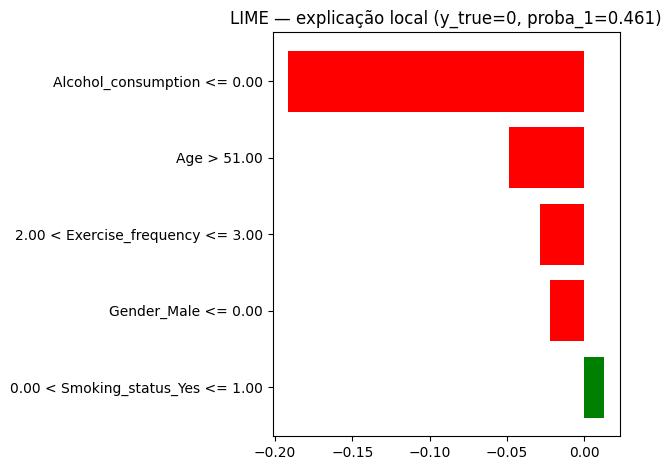

{
  "explained_test_index": 0,
  "true_label": 0,
  "pred_proba_positive": 0.4607021951230681,
  "top_features": [
    [
      "Alcohol_consumption <= 0.00",
      -0.1913476365904134
    ],
    [
      "Age > 51.00",
      -0.048510124095914785
    ],
    [
      "2.00 < Exercise_frequency <= 3.00",
      -0.028473753327417643
    ],
    [
      "Gender_Male <= 0.00",
      -0.02196552367137782
    ],
    [
      "0.00 < Smoking_status_Yes <= 1.00",
      0.012826946199085644
    ]
  ],
  "saved": {
    "png": "reports/lime_explanation.png",
    "html": "reports/lime_explanation.html"
  }
}


/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [14]:
from lime.lime_tabular import LimeTabularExplainer
def _fallback_make_target(df: pd.DataFrame) -> pd.Series:
    return (df["Sleep efficiency"] < 0.85).astype(int)

def _fallback_circ(ts):
    if pd.isna(ts): return (np.nan, np.nan)
    rad = (ts.hour + ts.minute/60.0)/24.0 * 2*np.pi
    return (np.cos(rad), np.sin(rad))

def _fallback_engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    bt = pd.to_datetime(df.get("Bedtime"), errors="coerce")
    wu = pd.to_datetime(df.get("Wakeup time"), errors="coerce")
    bt_cs = bt.apply(_fallback_circ).apply(pd.Series)
    wu_cs = wu.apply(_fallback_circ).apply(pd.Series)
    df["bt_cos"], df["bt_sin"] = bt_cs[0], bt_cs[1]
    df["wu_cos"], df["wu_sin"] = wu_cs[0], wu_cs[1]
    for col in ["Gender", "Smoking status"]:
        if col in df.columns: df[col] = df[col].astype("category")
    df = pd.get_dummies(df, columns=[c for c in ["Gender","Smoking status"] if c in df.columns], drop_first=True)
    keep = ["bt_cos","bt_sin","wu_cos","wu_sin","Caffeine intake","Alcohol consumption","Exercise frequency","Age"] \
           + [c for c in df.columns if c.startswith("Gender_") or c.startswith("Smoking status_")]
    df = df.reindex(columns=keep)
    df.columns = df.columns.str.replace(r"\s+","_",regex=True)
    df = df.loc[:, df.notna().any(axis=0)]
    const = df.nunique(dropna=False) <= 1
    df = df.loc[:, ~const]
    return df

def _fallback_sanitize(Xf: pd.DataFrame, y: pd.Series):
    Xf = Xf.copy()
    Xf.columns = Xf.columns.map(lambda c: str(c).strip().replace(" ","_"))
    for col in Xf.columns:
        if not np.issubdtype(Xf[col].dtype, np.number):
            Xf[col] = pd.to_numeric(Xf[col], errors="coerce")
    Xf = Xf.loc[:, Xf.notna().any(axis=0)]
    const_mask = Xf.nunique(dropna=False) <= 1
    if const_mask.any(): Xf = Xf.loc[:, ~const_mask]
    arr = Xf.to_numpy(dtype=float, copy=False)
    finite_mask = np.isfinite(arr).all(axis=1)
    Xf = Xf.loc[finite_mask]
    y = y.loc[Xf.index].astype(int)
    Xf = Xf.dropna(axis=0)
    y = y.loc[Xf.index]; y.index = Xf.index
    return Xf, y

if "df" in globals():
    _df = df.copy()
else:
    _df = pd.read_csv(DATA_PATH)

_make_target = globals().get("make_target", _fallback_make_target)
_engineer    = globals().get("engineer",    _fallback_engineer)
_sanitize    = globals().get("sanitize_features_targets", _fallback_sanitize)

y_full = _make_target(_df)
Xf_full = _engineer(_df)
Xf_full, y_full = _sanitize(Xf_full, y_full)

groups_all = _df.get("Subject ID", pd.Series(np.arange(len(_df), dtype=int), index=_df.index))
groups_all = pd.Series(groups_all).loc[Xf_full.index]
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
tr_idx, te_idx = next(gss.split(Xf_full, y_full, groups=groups_all))
X_tr, X_te = Xf_full.iloc[tr_idx], Xf_full.iloc[te_idx]
y_tr, y_te = y_full.iloc[tr_idx], y_full.iloc[te_idx]

if "final_model" in globals():
    model = final_model
else:
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False) if np.any((X_tr.dtypes==np.float64) & (X_tr.min()==0)) else StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))
    ])
    model.fit(X_tr, y_tr)

feature_names = list(X_tr.columns)
class_names = ["efficient(0)", "inefficient(1)"]

explainer = LimeTabularExplainer(
    training_data=X_tr.values,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True,      
    sample_around_instance=True,   
    random_state=123
)

X_tr = X_tr.astype(float)
X_te = X_te.astype(float)

def predict_proba_fn(x_np):
    """
    Coage a entrada para float e tenta prever com o modelo.
    Usa ndarray por padrão; se o modelo exigir DataFrame com colunas,
    cai no fallback com DataFrame mantendo a ordem de feature_names.
    """
    x_arr = np.asarray(x_np, dtype=float)
    try:
        return model.predict_proba(x_arr)
    except Exception:
        X_df = pd.DataFrame(x_arr, columns=feature_names)
        for c in X_df.columns:
            X_df[c] = pd.to_numeric(X_df[c], errors="coerce")
        try:
            return model.predict_proba(X_df)
        except Exception:
            return model.predict_proba(X_df.values)



i = 0  
x0 = X_te.iloc[i].values
y0 = int(y_te.iloc[i])

exp = explainer.explain_instance(
    data_row=x0,
    predict_fn=predict_proba_fn,
    num_features=min(10, len(feature_names)),
    num_samples=5000
)

fig = exp.as_pyplot_figure(label=1)
plt.title(f"LIME — explicação local (y_true={y0}, proba_1={predict_proba_fn(x0.reshape(1,-1))[0,1]:.3f})")
plt.tight_layout()
png_path = REPORTS_DIR / "lime_explanation.png"
plt.savefig(png_path, dpi=150)
plt.show()

html_path = REPORTS_DIR / "lime_explanation.html"
with open(html_path, "w", encoding="utf-8") as f:
    f.write(exp.as_html())

proba = predict_proba_fn(x0.reshape(1,-1))[0,1]
print(json.dumps({
    "explained_test_index": int(X_te.index[i]),
    "true_label": y0,
    "pred_proba_positive": float(proba),
    "top_features": exp.as_list(label=1),
    "saved": {"png": str(png_path), "html": str(html_path)}
}, indent=2, ensure_ascii=False))

In [17]:
i = np.random.randint(0, X_te.shape[0])
x0 = X_te.iloc[i].to_numpy()
y0 = int(y_te.iloc[i])

exp = explainer.explain_instance(
    x0,
    predict_proba_fn,
    num_features=8,
    top_labels=1,
)

exp.show_in_notebook(show_table=True, show_all=False)


label = exp.available_labels()[0]        
local_exp = exp.as_map()[label]        

rows = []
for feat_idx, weight in local_exp:
    rows.append({
        "Feature": feature_names[feat_idx],
        "Value": x0[feat_idx],
        "Weight_LIME": float(weight),
        "Effect": "↑ prob(inefficient=1)" if weight > 0 else "↓ prob(inefficient=1)",
    })

lime_table = pd.DataFrame(rows).sort_values("Weight_LIME", ascending=False)

print(f"\nExemplo explicado: idx={i}, y_true={y0}, "
      f"proba_1={predict_proba_fn(x0.reshape(1, -1))[0,1]:.3f}")
display(lime_table)

/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Exemplo explicado: idx=81, y_true=0, proba_1=0.346


/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Feature,Value,Weight_LIME,Effect
0,Alcohol_consumption,0.0,0.188820,↑ prob(inefficient=1)
1,Age,57.0,0.055239,↑ prob(inefficient=1)
4,Smoking_status_Yes,1.0,-0.014942,↓ prob(inefficient=1)
3,Gender_Male,1.0,-0.018607,↓ prob(inefficient=1)
2,Exercise_frequency,1.0,-0.041250,↓ prob(inefficient=1)
